# SWORD River Demo

This Jupyter Notebook contains examples related to querying river reaches (segments) using the SWOT River Database (SWORD) and visualizing results and then querying related datasets for the identified spatial extent through NASA's Common Metadata Repository (CMR) search.

Example Use Case: In this example, we geospatially search a single river reach, multiple reaches, and river nodes within the database. We then use geospatial coordinates of the features (here river reaches/node along the Kasai River, a tributary of the Congo River in Africa) to query against a dataset in CMR, namely Pre SWOT Hydrology.

**Resources**
- SWOT River Database (SWORD) data can be found here: https://zenodo.org/record/4917236#.YTKLPd9lCST
- Other SWOT SWORD documentation can be found here: https://swot.jpl.nasa.gov/documents/4031/
- MEaSUREs - Pre-Surface Water and Ocean Topography (Pre-SWOT) Hydrology data can be found here: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT?sections=data

### Coompute Environment Requirements
This notebook can be run either locally or in AWS cloud. The dataset we are querying against is in the PO.DAAC cloud archive (POCLOUD) located in the NASA Earthdata Cloud hosted in AWS.

### Required Dependencies

There are three python dependencies that must be available to the python kernel running this notebook. 

- plotly (https://pypi.org/project/plotly/)
- kaleido (https://pypi.org/project/kaleido/)
- geojson (https://pypi.org/project/geojson/)

The next cell installs them when the cell is run.

In [1]:
!pip install plotly geojson kaleido

     |████████████████████████████████| 15.2MB 1.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/e4/8d/9e28e9af95739e6d2d2f8d4bef0b3432da40b7c3588fbad4298c1be09e48/geojson-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e0/f7/0ccaa596ec341963adbb4f839774c36d5659e75a0812d946732b927d480e/kaleido-0.2.1-py2.py3-none-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl


First, we **define a function to query a single reach, multiple reaches, or river nodes**. This function returns the properties of river reaches including name, length, coordinates as well as individual node properties.

In [2]:
import requests
import json
import geojson
import pprint
import plotly.graph_objects as go

from IPython.display import JSON, Image

def response_to_FeatureCollection(response):
    """
    This function will return a geojson.FeatureCollection representation of the features found
    in the provided response.
    Parameters
    ----------
    response : requests.Response
        Response object returned from a GET request on the rivers endpoint.
    Returns
    -------
    geojson.FeatureCollection
        FeatureCollection containing all features extracted from the response.
    """
    featureList = []
    for reach_id, reach_json in response.json()['results'].items():
        reach_feature = geojson.loads(json.dumps(reach_json['geojson']))
        reach_feature['properties']={k:v for k,v in reach_json.items() if k not in ['geojson', 'geometry']}
        featureList.append(reach_feature)
    featureCollection = geojson.FeatureCollection(featureList)
    return featureCollection

We **define another function to calculate the center coordinates of features**. This function returns the center of a single reach or multiple reaches. 

In [3]:
def estimate_center_of_FeatureCollection(featureCollection):
    """
    This function does a very simplistic estimation of the center of all features in the given FeatureCollection.
    Parameters
    ----------
    featureCollection : geojson.FeatureCollection
        Estimate the center lon, lat of this FeatureCollection.
    Returns
    -------
    tuple(float, float)
        Estimated center longitude, center latitude
    """
    lats = [xy[1] for feature in featureCollection['features'] for xy in feature['coordinates']]
    lons = [xy[0] for feature in featureCollection['features'] for xy in feature['coordinates']]

    center_lat = (min(lats) + max(lats)) / 2
    center_lon = (min(lons) + max(lons)) / 2
    
    return center_lon, center_lat

# Plot a Single River Reach

In this section, we query the Feature Translation Service (FTS) SWORD service using a single Reach ID (from SWORD). In this example, we use the river Reach ID `13227000061`. This ID represents a specific reach along the Kasai River, a tributary of the Congo River in Africa. 

In [4]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/13227000061")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 1,
 'results': {'13227000061': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '7.561 ms.'}


Now we can plot this reach and calculate the center of the reach so that we can visualize the reach properly.

20.9611425 -4.6221515


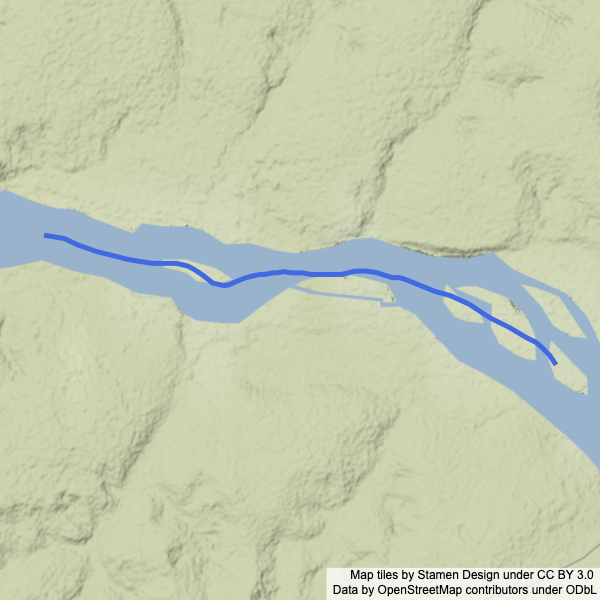

In [5]:
fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 12
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "line", 
        'line': {'width': 5},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])

center_lon, center_lat = estimate_center_of_FeatureCollection(featureCollection)

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

The below cell plots the river reach using an interactive map. You can zoom out to see where the reach is located.

In [6]:
fig.show()

Note that we haven't looked at any data from a collection yet, we've simmply found the geospatila coordinates of our river reach of interest. 

# Plot Multiple River Reaches

In this section, we query the FTS SWORD service over multiple river reaches. In this example, we use ID `132270000`. This ID represents multiple reaches along the Kasai River, a tributary of the Congo River in Africa. Note that this reach includes the reach ID of `13227000061` we plotted earlier. The response includes 9 individual reaches.

In [7]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/132270000")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 9,
 'results': {'13227000011': {...},
             '13227000021': {...},
             '13227000031': {...},
             '13227000041': {...},
             '13227000051': {...},
             '13227000061': {...},
             '13227000071': {...},
             '13227000081': {...},
             '13227000091': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '41.679 ms.'}


Now we can plot these multiple reaches and calculate  the center of the features.

20.7374665 -4.596502


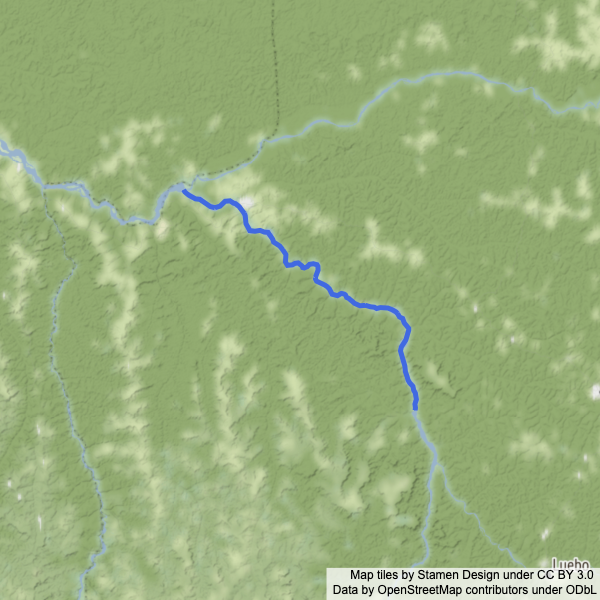

In [8]:
fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 8
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "line", 
        'line': {'width': 5},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])

center_lon, center_lat = estimate_center_of_FeatureCollection(featureCollection)

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

The below cell plots the river reaches using an interactive map. You can zoom out to see where these reaches are located.

In [9]:
fig.show()

# Plot River Nodes

In this section, we query the FTS SWORD service for river nodes. In this example, we use the ID of  `13227000060`. Note that this ID corresponds to the same reach ID `13227000061` we used earlier. The only difference is that the last digit of `0` corresponds to all the individual *nodes* along the reach. If the last digit is `1` in the reach ID, it corresponds to the overall properties of the *reach* itself. The response returns 52 nodes along the reach.

In [10]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/node/13227000060")

featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 52,
 'results': {'13227000060011': {...},
             '13227000060021': {...},
             '13227000060031': {...},
             '13227000060041': {...},
             '13227000060051': {...},
             '13227000060061': {...},
             '13227000060071': {...},
             '13227000060081': {...},
             '13227000060091': {...},
             '13227000060101': {...},
             '13227000060111': {...},
             '13227000060121': {...},
             '13227000060131': {...},
             '13227000060141': {...},
             '13227000060151': {...},
             '13227000060161': {...},
             '13227000060171': {...},
             '13227000060181': {...},
             '13227000060191': {...},
             '13227000060201': {...},
             '13227000060211': {...},
             '13227000060221': {...},
             '13227000060231': {...},
             '13227000060241': {...},
             '13227000060251': {...},
             '13227000060261': {...},

Now we can plot the river nodes and calculate the center of the nodes.

20.9613855 -4.6217735


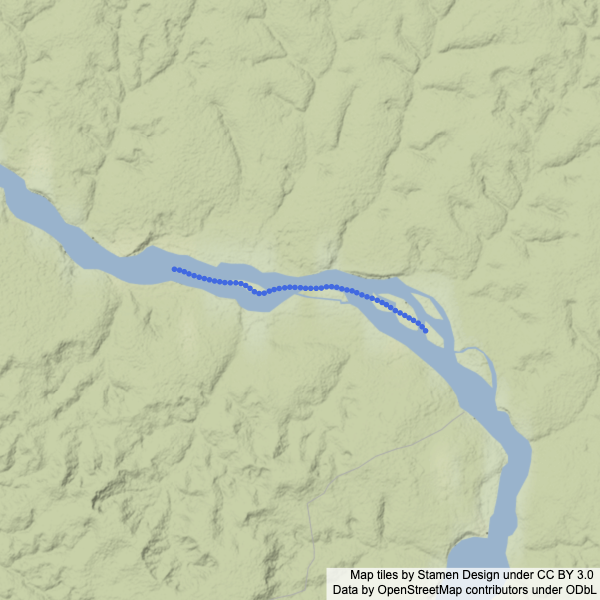

In [11]:

fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 11
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "circle", 
        'circle': {'radius': 3},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])

lats = [feature['coordinates'][1] for feature in featureCollection['features']]
lons = [feature['coordinates'][0] for feature in featureCollection['features']]

center_lat = (min(lats) + max(lats)) / 2
center_lon = (min(lons) + max(lons)) / 2

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

In [12]:
fig.show()

## Query CMR by Coordinates

We can use results obtained from the FTS query to then directly and automatically query data using CMR. We will use the coordinate information of a single reach to search for granules (files) available through the [Pre SWOT Hydrology GRRATS Daily River Heights](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) and Storage Version 2 data, which has the collection ID `C2036882359-POCLOUD`. 

We query FTS using the previously used reach ID of `13227000061` over Kasai River, a tributary of the Congo River in Africa.

In [13]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/13227000061")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 1,
 'results': {'13227000061': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '5.389 ms.'}


The next cell queries CMR using the coordinates of the reach. Note that coordinates should be listed in the format lon1, lat1, lon2, lat2, lon3, lat3, and so on. The CMR json response proivides a link to the data file (granule) from the Pre SWOT Hydroology GRRATS Daily River Heights data collection that overlaps the geospatial search from FTS-SWORD for the river reaches of interest, e.g. `
 "href": "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2/Africa_Congo1kmdaily.nc"`

In [15]:
COLLECTION_ID = "C2036882359-POCLOUD" #  Pre SWOT Hydrology GRRATS Daily River Heights and Storage Version 2

# derive lon,lat bounds of nodes along the reach
lats = [xy[1] for feature in featureCollection['features'] for xy in feature['coordinates']]
lons = [xy[0] for feature in featureCollection['features'] for xy in feature['coordinates']]

# find max and min of lat and lon
maxlat, maxlon, minlat, minlon = max(lats), max(lons), min(lats), min(lons)

# create one single list of lon,lat coordinates that creates a bounding box of extent
coord_list = [maxlon, maxlat, maxlon, minlat, minlon, maxlat, minlon, minlat]

# create a string of the list to input into CMR
coord_list_string = str(coord_list)[1:-1]
lonlat_bbox = coord_list_string.replace(" ", "")

# query CMR
cmr_response = requests.get("https://cmr.earthdata.nasa.gov/search/granules.json?line={}&echo_collection_id={}&pretty=True".format(lonlat_bbox, COLLECTION_ID))

# Print out results
print(json.dumps(cmr_response.json(), indent = 4))

{
    "feed": {
        "updated": "2022-06-08T14:11:18.434Z",
        "id": "https://cmr.earthdata.nasa.gov:443/search/granules.json?line=21.005094,-4.611049,21.005094,-4.633254,20.917191,-4.611049,20.917191,-4.633254&echo_collection_id=C2036882359-POCLOUD&pretty=True",
        "title": "ECHO granule metadata",
        "entry": [
            {
                "boxes": [
                    "-6.013 12.708 2.185 25.948"
                ],
                "time_start": "1992-05-01T20:48:54.000Z",
                "updated": "2022-03-11T19:11:49.948Z",
                "dataset_id": "Pre SWOT Hydrology GRRATS Daily River Heights and Storage Version 2",
                "data_center": "POCLOUD",
                "title": "Africa_Congo1kmdaily",
                "coordinate_system": "CARTESIAN",
                "day_night_flag": "UNSPECIFIED",
                "time_end": "2018-04-19T22:01:11.000Z",
                "id": "G2105958909-POCLOUD",
                "original_format": "UMM_JSON",
      

From all that was printed out above, we want to hone in specifically on the granule file from the Pre-SWOT MEaSUREs dataset that gives us the data over our desired region.

In [16]:
granule = cmr_response.json()['feed']['entry'][0]['id']
granule

'G2105958909-POCLOUD'

If we want to direct download to our local machine, we want the link with the title `Download Africa_Congo1kmdaily.nc`. If we want to directly access this granule in the cloud, we want the link entitled, `This link provides direct download access via S3 to the granule`. Here, we access the netCDF file links and print them out respectively. From here, you're ready to access the data either locally or via cloud direct access!

It should be noted that the links are not always in the same order across datasets (collections), and thus referencing other datasets with the '[0]' and '[1]' indexes may not work for the download and s3 links respectively. For direct download, the link should always start with "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/", and for direct cloud access to PO.DAAC data, the link should start with "s3://podaac-ops-cumulus-protected/" no matter the dataset.

In [17]:
granule_download_link = cmr_response.json()['feed']['entry'][0]['links'][0]['href']
granule_cloud_s3_link = cmr_response.json()['feed']['entry'][0]['links'][1]['href']
granule_download_link, granule_cloud_s3_link

('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2/Africa_Congo1kmdaily.nc',
 's3://podaac-ops-cumulus-protected/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2/Africa_Congo1kmdaily.nc')

(Note: the cell above just prints the links of interest for either downloading the file, or accessing from the cloud. It didn't yet download or access the data. That would be your next step.)